David Diaz <br>
INFX 562 (Spring 2018)

# The Question
How do estimates of forest growth and yield produced by the Forest Vegetation Simulator (FVS) compare to historical and contemporary data and accounts? Are additional adjustments needed to the model to make it more accurate or informative for decision-making?

# The Data Sources
In this project, I considered four general data sources:
1. Data I produced using the the Forest Vegetation Simulator
2. Several published Yield Tables for Douglas-fir
3. Remeasurements from permanent forest research plots published in the literature
4. Plot measurements collected from Oregon and Washington by the USDA Forest Service's Forest Inventory & Analysis (FIA) program.

#### 1. Forest Vegetation Simulator

The [Forest Vegetation Simulator (FVS)](https://www.fs.fed.us/fvs/index.shtml) is an [open-source](https://sourceforge.net/projects/open-fvs/) project of the USDA Forest Service, which they succinctly describe as:
>*`The Forest Vegetation Simulator (FVS) is a forest growth simulation model. It simulates forest vegetation change in response to natural succession, disturbances, and management. It recognizes all major tree species and can simulate nearly any type of management or disturbance at any time during the simulation. Outputs include tree volumes, biomass, density, canopy cover, harvest yields, fire effects, and much, much more.`*

I performed 230 stochastic simulations of the development of Douglas-fir plantations from establishment up to 200 years of age using the ORGANON Pacific Coast [Variant](https://www.fs.fed.us/fmsc/ftp/fvs/docs/overviews/FVSop_Overview.pdf) of FVS. These simulations were executed using a parallel processing workflow developed in Python using Jupyter Notebooks. 

Site Index is a measure of the productive potential of a site, and describes the average height of dominant trees reached in a forest stand at some benchmark age (usually 50 or 100 years). More productive sites yield taller and larger trees more quickly, and thus have higher Site Indices than less productive sites. Simulations were run for Site Indices ranging from 50 to 160 using a step of 5.  This produced 23 different Site Index values, each of which was simulated stochastically 10 times.

#### 2. Long-term Plot Data
I transcribed data from a couple of the studies that have conducted long-term measurements of forest plots to  investigate the changes in forest conditions over time have been published. These data provide a deep (in terms of time), but relatively narrow (in terms of number of independent plots) glimpse at forest growth and yield: 
>`Curtis, R.O., Marshall, D.D. (2002). "Levels-of-growing-stock cooperative study in Douglas-fir: report no. 14—Stampede Creek, 30-year results" (Research Paper No. PNW-RP-543). U.S. Department of Agriculture, Forest Service, Pacific Northwest Research Station, Portland, OR.` [link to PDF](https://www.fs.fed.us/pnw/pubs/pnw_rp543.pdf)

>`Williamson, R.L. (1963). "Growth and yield records from well-stocked stands of Douglas-fir" (Research Paper No. PNW-RP-4). U.S. Department of Agriculture, Forest Service, Pacific Northwest Forest and Range Experiment Station, Portland, OR.` [link to PDF](https://www.fs.fed.us/pnw/olympia/silv/publications/opt/74_Williamson1963.pdf)

####  3. FIA Data
Thousands of forest inventory plots are measured every year by the USDA Forest Service across the country. These data provide a broad (in terms of number of independent plots), but relatively shallow (in terms of measurements over time) overview of forest growth and yield. FIA data was downloaded for Oregon and Washington, and results for Douglas-fir forests were queried from these databases.

These data were queried from the Access databases, and cleaned/formatted in Microsoft Excel. 

In [1]:
import pandas as pd
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set_style('darkgrid')

#### Read the FVS simulation data from the PostgreSQL database

In [3]:
conn = psycopg2.connect("dbname='Rotations' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT summary.*, cases.mgmtid, CAST (cases.standid AS INT) AS siteindex
FROM summary, cases
WHERE summary.caseid = cases.caseid AND cases.mgmtid = 'GROW';
'''
# read the query into a pandas dataframe
grow = pd.read_sql(SQL, conn)
conn.close()

In [4]:
# add a new variable, siteclass, to the dataframe by binning site index into categories
grow['siteclass'] = pd.cut(grow.siteindex, bins=[0,75,95,115,135,160], labels=[5, 4, 3, 2, 1]).astype('int')
# calculate thousands of board feet and hundreds of cubic feet
grow['MBF'] = grow.bdft / 1000
grow['tcuft_CCF'] = grow.tcuft / 100
grow['mcuft_CCF'] = grow.mcuft / 100

In [5]:
print(grow.columns)
cols = ['age', 'tpa', 'ba', 'sdi', 'topht', 'qmd', 'MBF', 'tcuft_CCF']
grow[cols].describe()

Index(['caseid', 'standid', 'year', 'age', 'tpa', 'ba', 'sdi', 'ccf', 'topht',
       'qmd', 'tcuft', 'mcuft', 'bdft', 'rtpa', 'rtcuft', 'rmcuft', 'rbdft',
       'atba', 'atsdi', 'atccf', 'attopht', 'atqmd', 'prdlen', 'acc', 'mort',
       'mai', 'fortyp', 'sizecls', 'stkcls', 'mgmtid', 'siteindex',
       'siteclass', 'MBF', 'tcuft_CCF', 'mcuft_CCF'],
      dtype='object')


,age,tpa,ba,sdi,topht,qmd,MBF,tcuft_CCF
count,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000,9430.000000
mean,100.000000,195.019194,294.984093,416.696076,124.894804,17.119294,96.990059,160.083199
std,59.163935,81.499988,136.281415,163.924993,62.888186,7.761623,72.436612,104.766063
min,0.000000,1.000000,0.000000,0.000000,5.000000,0.100000,0.000000,0.000000
25%,50.000000,134.000000,216.000000,363.000000,80.000000,12.287275,35.364000,73.247500
50%,100.000000,186.000000,346.000000,500.000000,122.000000,18.195800,87.786500,156.770000
75%,150.000000,264.000000,402.000000,529.000000,172.000000,23.091575,151.991750,243.522500
max,200.000000,451.000000,485.000000,536.000000,269.000000,36.546600,325.808000,442.680000


Our data includes 10 different simulations I ran for each of 23 different levels of site index. For each level of site index, a stochastic simulation approach was used to allow variability in model outputs. We need to summarize data across these 10 runs to produce classical Yield Tables.

In [6]:
# to make Yield Tables, let's use the mean of the simulations
grow_group = grow.groupby(by=['siteindex', 'year']).mean().reset_index()

# replace NaN's with zeros
grow_group['MBF'] = grow_group['MBF'].replace(to_replace=np.nan, value=0)

In [7]:
# choose a value we want to generate a table for
metric = 'MBF'
tables = grow_group.loc[grow_group.year % 10 == 0] # trim the data to show every 10 years
tables = tables.loc[tables.siteindex % 10 == 0] # trim the data to show site indices in multiples of 10

# use a pivot table to show value by year (row) and site index (column)
tables.loc[tables.year >=20].pivot(index='year', # exclude ages <20
                                   columns='siteindex', 
                                   values=metric).style.format("{:,.1f}")

siteindex,50,60,70,80,90,100,110,120,130,140,150,160
year,,,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,5.8,8.3,9.0,12.2,12.7,14.6
30,0.0,0.0,5.8,9.5,13.6,17.8,20.3,21.5,25.2,32.1,34.5,38.6
40,5.9,10.1,16.3,19.6,24.6,30.5,36.3,41.5,46.2,53.4,60.5,62.7
50,10.7,17.4,22.2,28.9,37.4,45.2,50.6,56.2,65.7,73.1,81.9,87.0
60,17.5,22.9,35.1,38.0,49.6,58.6,66.4,73.7,81.5,90.8,102.6,108.4
70,23.2,29.9,42.0,47.3,60.6,69.5,78.4,86.9,97.8,108.7,121.8,130.9
80,26.3,35.5,49.6,54.8,70.2,81.0,89.9,101.6,112.3,125.3,138.9,148.4
90,29.8,40.8,55.1,62.2,82.2,94.2,101.0,117.4,125.2,139.1,151.9,165.2
100,36.3,46.0,62.2,69.5,91.9,103.2,110.7,125.1,135.2,149.0,166.2,177.3


## Visualize the data from all of our our simulations

In [8]:
grow = grow.sort_values(by=['siteclass', 'caseid', 'year'])

#### Show all the FVS data grouped by Site Index

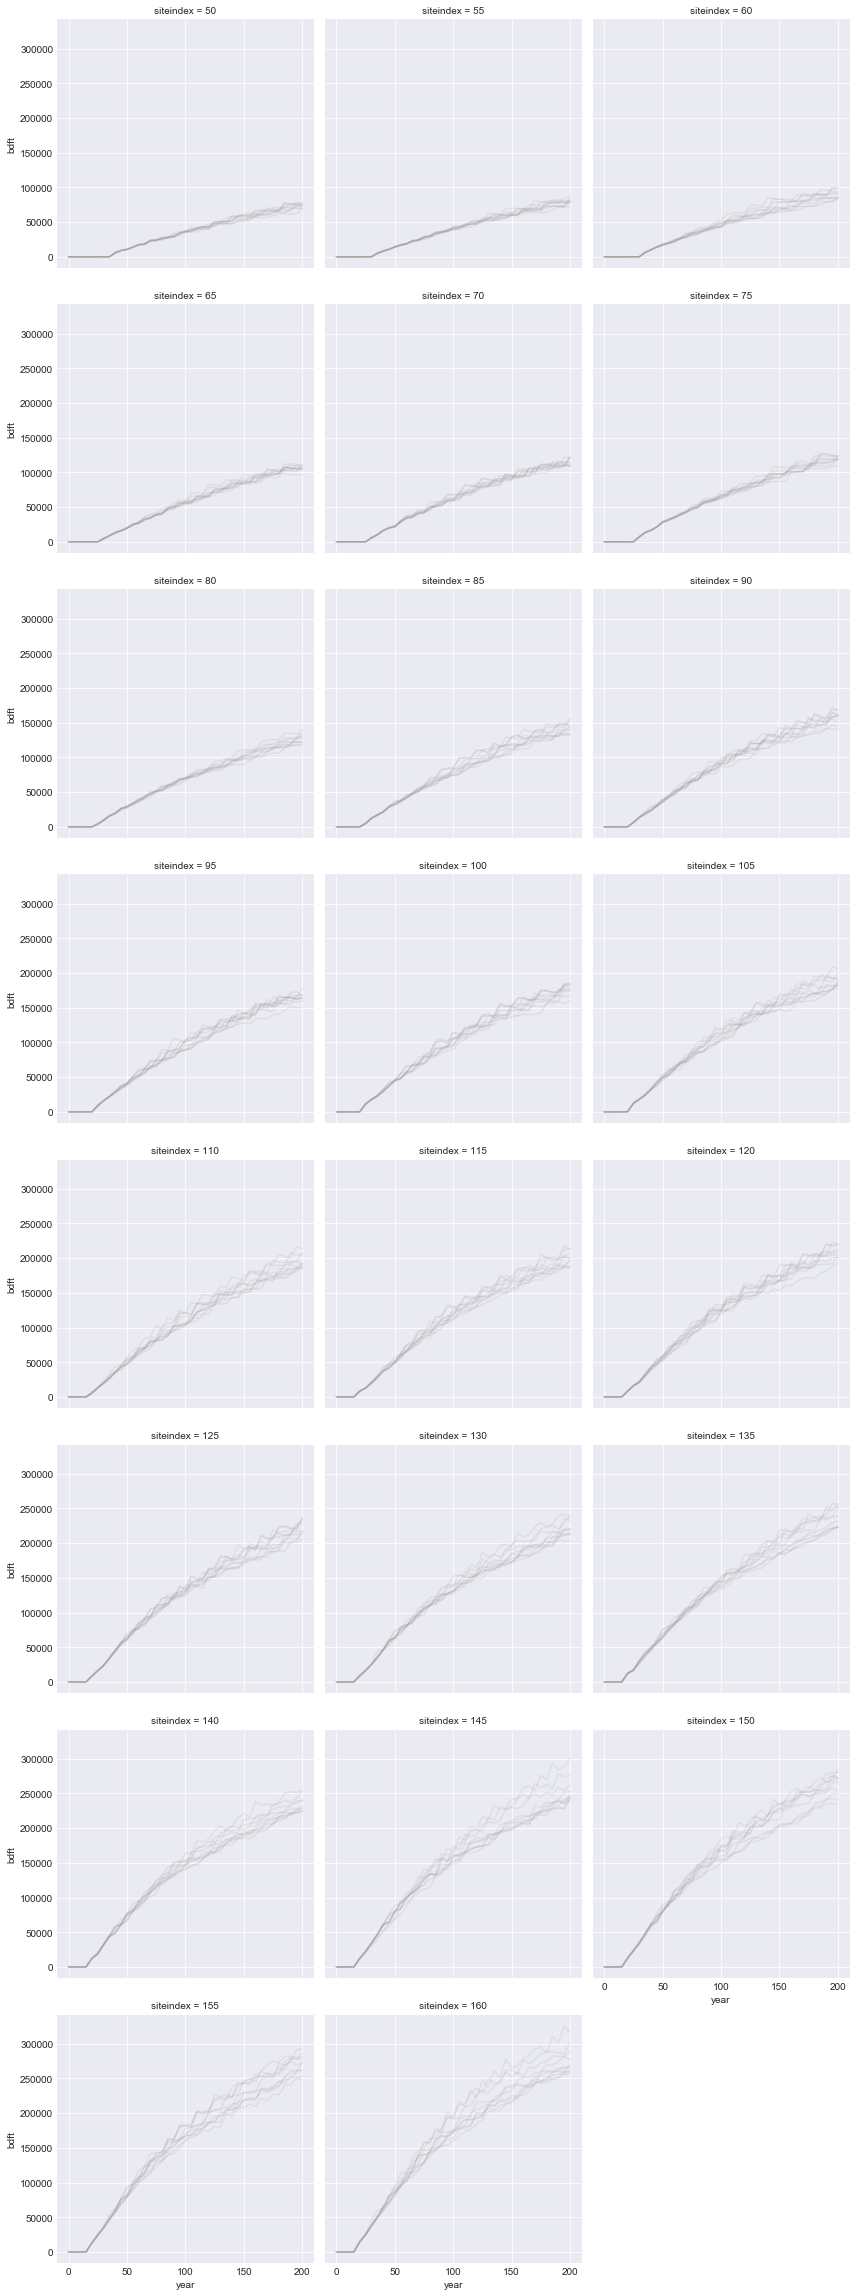

In [9]:
g = sns.FacetGrid(data=grow, col='siteindex', hue='caseid', 
                  col_wrap=3, size=4, sharey=True, sharex=True,
                 palette=sns.color_palette('Greys',1))
g = g.map(plt.plot, 'year', 'bdft', alpha=0.15)

#### Show all the FVS data grouped into the five Site Classes

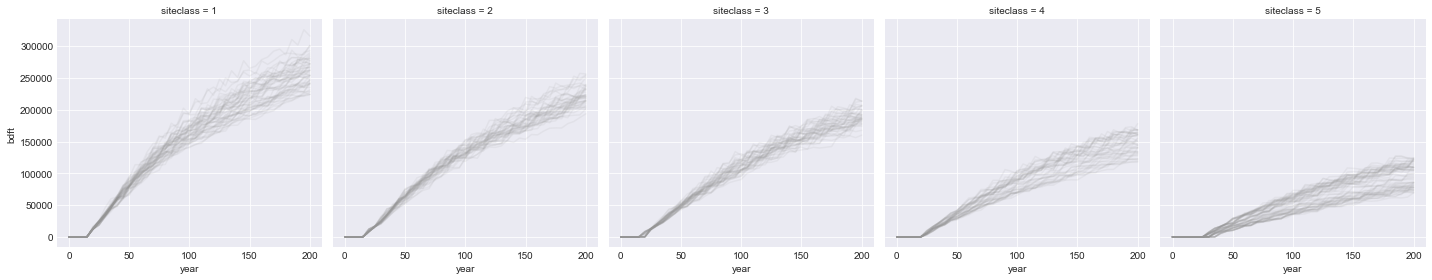

In [10]:
g = sns.FacetGrid(data=grow, col='siteclass', hue='caseid', 
                  palette=sns.color_palette('Greys',1),
                  size=4, sharey=True, sharex=True)
g = g.map(plt.plot, 'year', 'bdft', alpha=0.10)

## Visualize the data from the FIA Databases

In [11]:
fia = pd.read_csv('FIA_conds.csv')
print(fia.columns)
fia.describe()

Index(['condid', 'state', 'site_baseage', 'siteclass', 'site_species',
       'forest_type', 'siteindex_orig', 'stand_age', 'BA', 'QMD', 'TPA',
       'total_cubic_net', 'total_cubic_gross', 'sawlog_cubic_net',
       'sawlog_cubic_gross', 'boardfoot_net', 'boardfoot_gross'],
      dtype='object')


,condid,site_baseage,siteclass,site_species,forest_type,siteindex_orig,stand_age,BA,QMD,TPA,total_cubic_net,total_cubic_gross,sawlog_cubic_net,sawlog_cubic_gross,boardfoot_net,boardfoot_gross
count,5.397000e+03,5397.000000,5397.000000,5397.0,5397.0,5397.000000,5397.000000,5397.000000,5397.000000,5397.000000,5397.000000,5397.000000,5397.000000,5397.000000,5397.000000,5397.000000
mean,1.784318e+14,96.868631,4.104317,202.0,201.0,103.480452,100.480637,198.292084,6.074904,177.704202,5364.311443,5920.556565,4555.557063,4662.850378,29628.721203,30341.000873
std,1.576986e+14,12.115700,0.732375,0.0,0.0,21.984129,86.503964,440.866865,2.507652,344.137650,4929.583171,5542.517794,4556.799675,4670.304339,31701.778115,32513.212526
min,4.475710e+11,50.000000,1.000000,202.0,201.0,15.000000,0.000000,3.480000,2.547244,0.990000,32.260000,36.290000,13.570000,19.870000,58.170000,78.020000
25%,2.296206e+13,100.000000,4.000000,202.0,201.0,88.000000,40.000000,104.040000,4.346457,96.280000,1687.760000,1843.610000,1169.940000,1192.410000,6770.590000,6908.440000
50%,1.774492e+14,100.000000,4.000000,202.0,201.0,104.000000,80.000000,170.400000,5.460630,156.460000,3785.850000,4135.480000,2979.340000,3022.980000,17958.990000,18387.240000
75%,3.022475e+14,100.000000,5.000000,202.0,201.0,120.000000,125.000000,251.370000,7.086614,228.680000,7574.870000,8247.940000,6519.910000,6657.940000,41682.900000,42651.840000
max,4.511326e+14,100.000000,5.000000,202.0,201.0,187.000000,750.000000,30965.540000,26.771654,24072.180000,34599.400000,40804.040000,33157.590000,34031.940000,236865.110000,242902.720000


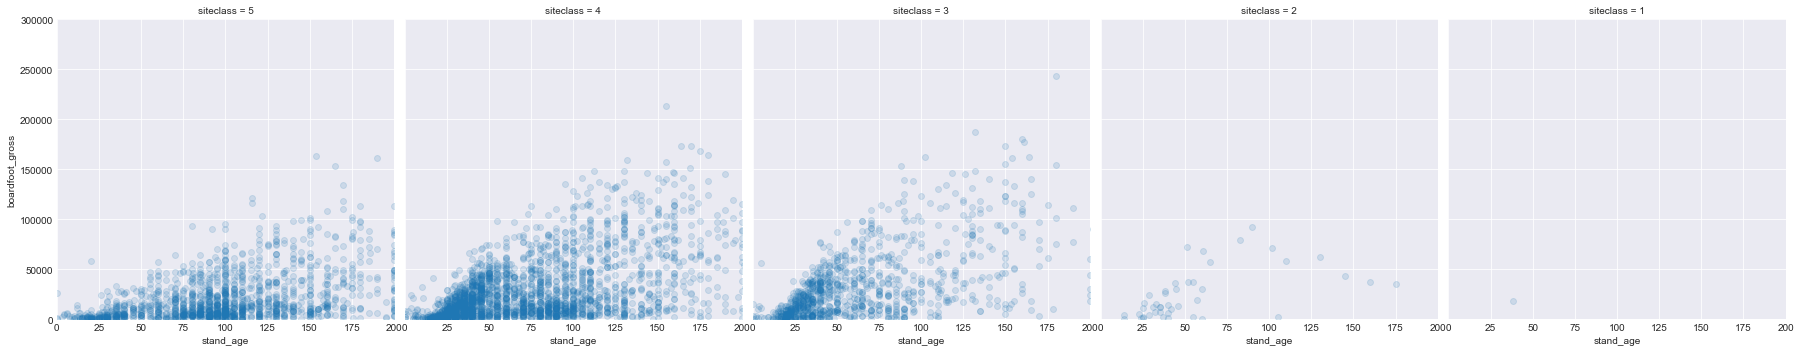

In [12]:
g = sns.lmplot(data=fia, x='stand_age', y='boardfoot_gross', col='siteclass', col_order=[5, 4, 3, 2, 1],
          fit_reg=False, ci=None, x_ci=None, scatter_kws={'alpha':0.15})
g.set(xlim=(0,200))
g.set(ylim=(0,300000));

#### Try with hexbins instead of a scatter plot

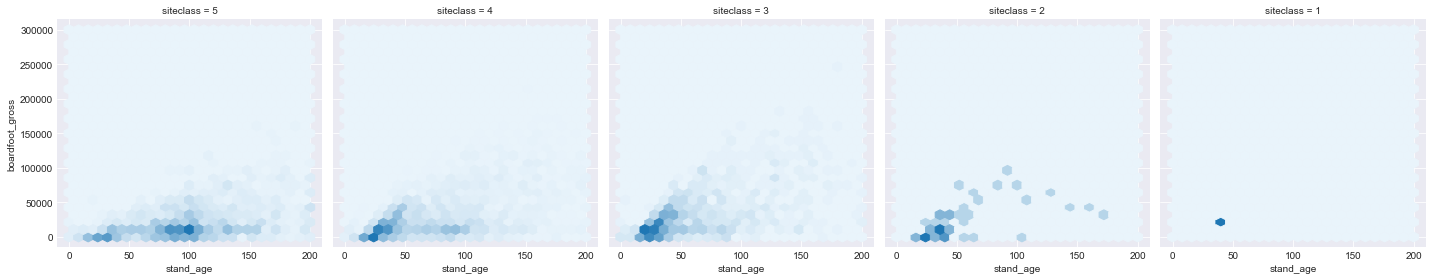

In [13]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(fia, col="siteclass", col_order=[5,4,3,2,1], size=4)
g.map(hexbin, "stand_age", "boardfoot_gross", extent=[0, 200, 0, 300000]);

This way of viewing the data shows density where more plots were observed, but this isn't quite what I'm intending to capture. I'd prefer to know what a reasonable range of timber volume (boardfoot gross) might be at each age. Instead, the hexbin washes out the older ages because there are fewer samples. 

Let's bin the ages into 10-year intervals and then graph the mean timber volume over time for each site class.

In [14]:
fia['stand_age_10'] = fia.stand_age // 10 * 10
fia_group = fia.groupby(by=['siteclass', 'stand_age_10']).agg(['mean', 'std', 'count'])['boardfoot_gross']

#### Seaborn makes it look like the data are continuous across min/max observed ages

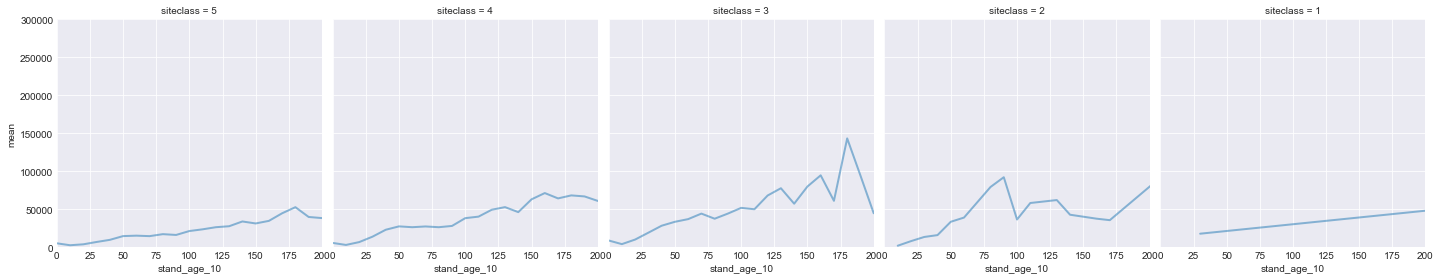

In [15]:
g = sns.FacetGrid(data=fia_group.reset_index(), col='siteclass', col_order=[5,4,3,2,1], 
                  palette=sns.color_palette('Blues',1),
                  size=4, sharey=True, sharex=True)
g = g.map(plt.plot, 'stand_age_10', 'mean', alpha=0.50, lw=2.0)
g.set(xlim=(0,200))
g.set(ylim=(0,300000));

#### But plotting directly from grouped and pivoted dataframe shows gaps in observed ages

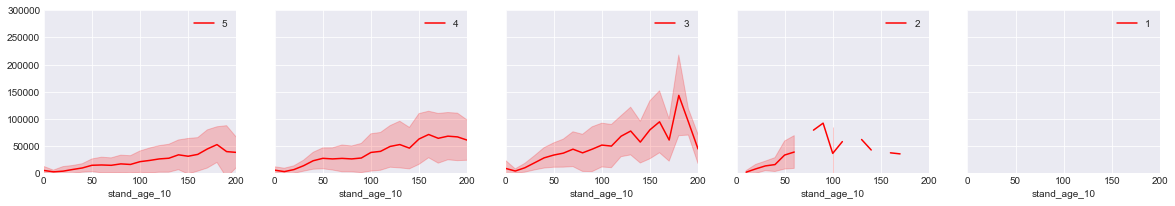

In [16]:
fig, axs = plt.subplots(1,5, figsize=(20,3), sharey=True, sharex=True)
fia_pivot = pd.pivot_table(fia_group.reset_index(), 
               index='stand_age_10', columns='siteclass', values=['mean', 'std'])
fia_pivot = fia_pivot.sort_index(axis=1, ascending=False)
fia_pivot['mean'].plot(subplots=True, legend=True, ax=axs, style=['r','r','r','r', 'r'])
for i in range(2,6):
    axs[5-i].fill_between(x=fia_pivot.index, 
                          y1=fia_pivot['mean'][i]-fia_pivot['std'][i], 
                          y2=fia_pivot['mean'][i]+fia_pivot['std'][i],
                          alpha=0.2, color='r')
plt.xlim(0,200)
plt.ylim(0,300000);

## Visualize the data from the permanent plots

In [17]:
perm = pd.read_csv('PermanentPlots.csv')
print(perm.columns)
perm.describe()

Index(['Source', 'ID', 'Location', 'Plot', 'si100', 'siteclass', 'age',
       'boardfeet_scribner', 'total_cubic', 'si50'],
      dtype='object')


,Plot,si100,siteclass,age,boardfeet_scribner,total_cubic,si50
count,240.000000,219.000000,240.000000,240.000000,238.000000,238.000000,21.0
mean,14.004167,160.735160,2.416667,70.675000,50611.273109,11095.726891,111.0
std,29.363755,24.226061,0.813930,19.885041,27372.543262,3787.857376,0.0
min,1.000000,116.000000,1.000000,33.000000,980.000000,2211.000000,111.0
25%,2.000000,141.000000,2.000000,55.000000,29315.500000,8460.000000,111.0
50%,4.000000,170.000000,2.000000,67.000000,49175.000000,11120.000000,111.0
75%,7.000000,175.000000,3.000000,83.000000,69212.000000,13367.000000,111.0
max,122.000000,205.000000,4.000000,119.000000,143848.000000,25716.000000,111.0


In [18]:
perm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 10 columns):
Source                240 non-null object
ID                    240 non-null object
Location              240 non-null object
Plot                  240 non-null int64
si100                 219 non-null float64
siteclass             240 non-null int64
age                   240 non-null float64
boardfeet_scribner    238 non-null float64
total_cubic           238 non-null float64
si50                  21 non-null float64
dtypes: float64(5), int64(2), object(3)
memory usage: 18.8+ KB


In [19]:
perm = perm.dropna(subset=['boardfeet_scribner'])
perm = perm.sort_values(by=['siteclass', 'ID', 'age'])

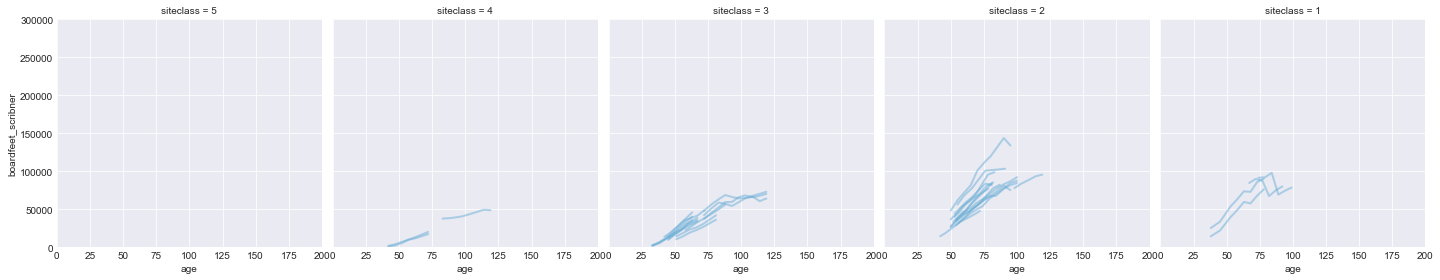

In [20]:
g = sns.FacetGrid(data=perm, col='siteclass', col_order=[5,4,3,2,1], hue='ID', 
                  palette=sns.color_palette('Blues',1),
                  size=4, sharey=True, sharex=True)
g = g.map(plt.plot, 'age', 'boardfeet_scribner', alpha=0.50, lw=2.0)
g.set(xlim=(0,200))
g.set(ylim=(0,300000));

## Prepare a final graphic that integrates FVS Simulations and field-observed data

In [21]:
perm_pivot = pd.pivot_table(perm, index=['ID', 'age'], columns='siteclass', values='boardfeet_scribner')
perm_pivot = perm_pivot.sort_index(axis=1, ascending=False)
grow_pivot = pd.pivot_table(grow, index=['caseid', 'age'], columns='siteclass', values='bdft')
grow_pivot = grow_pivot.sort_index(axis=1, ascending=False)

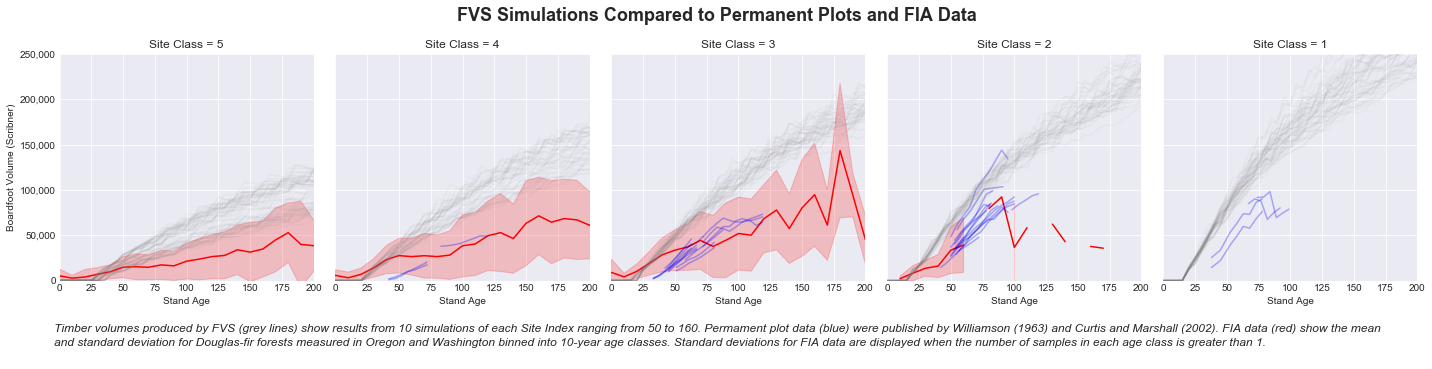

In [22]:
fig, axs = plt.subplots(1,5, figsize=(20,5), sharey=True, sharex=True)
fia_pivot['mean'].plot(subplots=True, legend=False, ax=axs, style=['r']*5)
for i in range(2,6):
    axs[5-i].fill_between(x=fia_pivot.index, 
                          y1=fia_pivot['mean'][i]-fia_pivot['std'][i], 
                          y2=fia_pivot['mean'][i]+fia_pivot['std'][i],
                          alpha=0.2, color='r')

perm_pivot.reset_index(level=1).groupby('ID').plot(x='age', 
                                                   subplots=True, legend=False, 
                                                   ax=axs[1:], style=['b']*4, alpha=0.3)

grow_pivot.reset_index(level=1).groupby('caseid').plot(x='age', 
                                                   subplots=True, legend=False, 
                                                   ax=axs, style=['gray']*5, alpha=0.05)

# create titles and axis labels for each subplot
for i in range(5): 
    axs[i].set_title('Site Class = '+str(5-i))
    axs[i].set(xlabel='Stand Age')
axs[0].set(ylabel='Boardfoot Volume (Scribner)')

# set limits of axes
plt.xlim(0,200)
plt.ylim(0,250000)
# reformat ticks to have thousand separators
axs[0].set_yticklabels(['{:,}'.format(int(x)) for x in axs[0].get_yticks().tolist()])

fig.suptitle('FVS Simulations Compared to Permanent Plots and FIA Data', 
             fontsize=18, fontweight='bold')
plt.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.22)
caption = '''
Timber volumes produced by FVS (grey lines) show results from 10 simulations \
of each Site Index ranging from 50 to 160. Permament plot data (blue) were published by \
Williamson (1963) and Curtis and Marshall (2002). FIA data (red) show the mean 
and standard deviation for Douglas-fir forests measured in Oregon and Washington binned \
into 10-year age classes. Standard deviations for FIA data are displayed when the \
number of samples in each age class is greater than 1.
'''
plt.figtext(0.04, 0, caption, wrap=True, 
            style='italic', fontsize=12,
           linespacing=1.5)
plt.savefig('FVS_vs_Data.png');

This figure demonstrates that FVS tends to produce estimates of timber volume that are usually higher than the volumes observed on FIA and permanent plots. This justifies further investigation into other stand-level metrics (such as total cubic volume, average diameter, basal area, and trees per acre) to determine whether this bias also appears in those values, or whether it is limited to the calculations of boardfoot volume. If the bias is limited to boardfoot volume estimates, a direct adjustment to solely the volume calculation may be appropriate. If the bias is pervasive across all stand attributes, adjustments to underlying growth and/or mortality rates of FVS may be required.